### INSTALLING REQUIRED LIBRARIES TO LEVERAGE LATEST KERAS FUNCTIONS

In [168]:
#pip uninstall keras-preprocessing

In [169]:
#conda install git

In [170]:
#pip install git+https://github.com/keras-team/keras-preprocessing.git

In [171]:
# importing required libraries

import os
import tensorflow as tf
import datetime
from tensorflow import keras
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
%load_ext tensorboard


from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers





The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [172]:
 #writer = tf.summary.create_file_writer(r"C:\Users\conno\Documents\fit")

In [173]:
# Clear any logs from previous runs

#!rm -rf "C:\Users\conno\Downloads\work\1. Study(main objective)\Artificial Intelligence\4. Intellipaat AI course\Modules\3. AI(DEEP LEARNING)\Assignments\Live-class\Assignment-5\logs

## Question-1

The image matrix needs to be converted into a flattened array before feeding into the neural networks. It is fine but it has several disadvantages as well. The first disadvantage is that once we flatten the image matrix, we lose the original structure of it. The pattern get's distorted and the interaction between pixels is lost.

For instance, in the image below, in case of neural networks, the model will be able to identify the image of 4 only if it is the centre. If it is at the corner, or some other location, the the model will fail in that case because the pixels have been distorted.

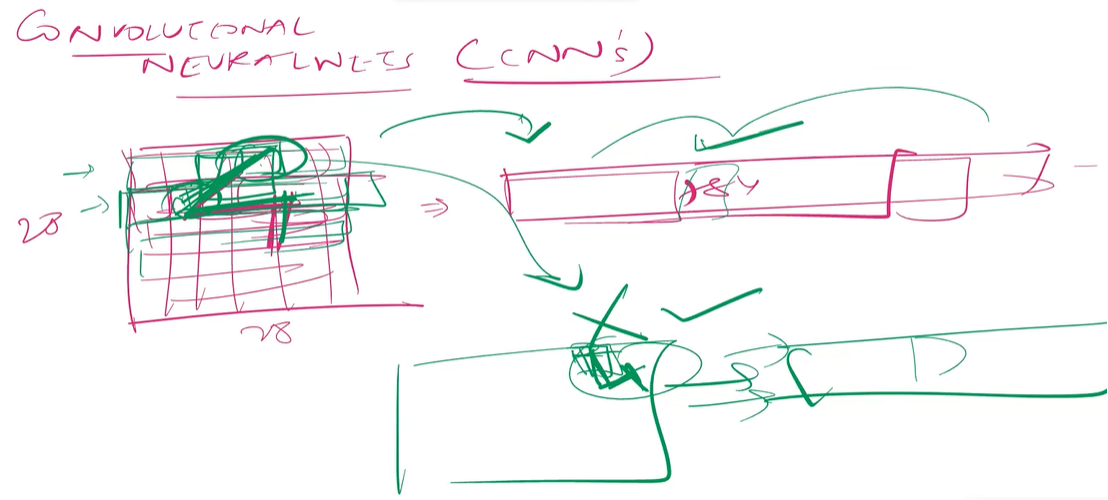


Another example can be of dog, Dog can have any expression and it might not see into the camera. Then in those cases, if we flatten out the input image. Then, the prediction might be incorrect.



Another disadvantage of layer flattening is that let's say we have a 1000 by 1000, 3 channel image, then the total inputs will be significantly high let's say 3*10^6 and hidden layers and output layer which is too computationally inefficient or will affect computational capabilities. So, we won't able to deal with large-sized, high quality images using layer flattening. 


### Question-2 

### Part a):- Performing EDA of the given dataset

### Reading the csv file

In [174]:
traindf = pd.read_csv('labels.csv', dtype=str)

In [175]:
traindf.shape

(10222, 2)

In [176]:
traindf.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [177]:
traindf

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [178]:
# let's see how many breeds(classes) are there
print("Breeds Present in CSV: ",len(traindf.breed.unique()))

Breeds Present in CSV:  120


In [179]:
## checking for null values

In [180]:
traindf.isnull().sum()

id       0
breed    0
dtype: int64

In [181]:
## counting the highest and lowest number of dog breeds

In [182]:
sorted_df= traindf.groupby('breed').count()
sorted_df

,id
breed,
affenpinscher,80
afghan_hound,116
african_hunting_dog,86
airedale,107
american_staffordshire_terrier,74
...,...
welsh_springer_spaniel,79
west_highland_white_terrier,81
whippet,95


In [183]:
sorted_df = sorted_df.reset_index()  # to reset the index

In [184]:
sorted_df = sorted_df.sort_values('id', ascending = False)

In [185]:
# checking first five rows

sorted_df.head(5)

,breed,id
97,scottish_deerhound,126
73,maltese_dog,117
1,afghan_hound,116
42,entlebucher,115
11,bernese_mountain_dog,114


In [186]:
# checking last 5 rowss

sorted_df.tail(5)

,breed,id
49,golden_retriever,67
22,brabancon_griffon,67
65,komondor,67
23,briard,66
43,eskimo_dog,66


## Visualizing the data

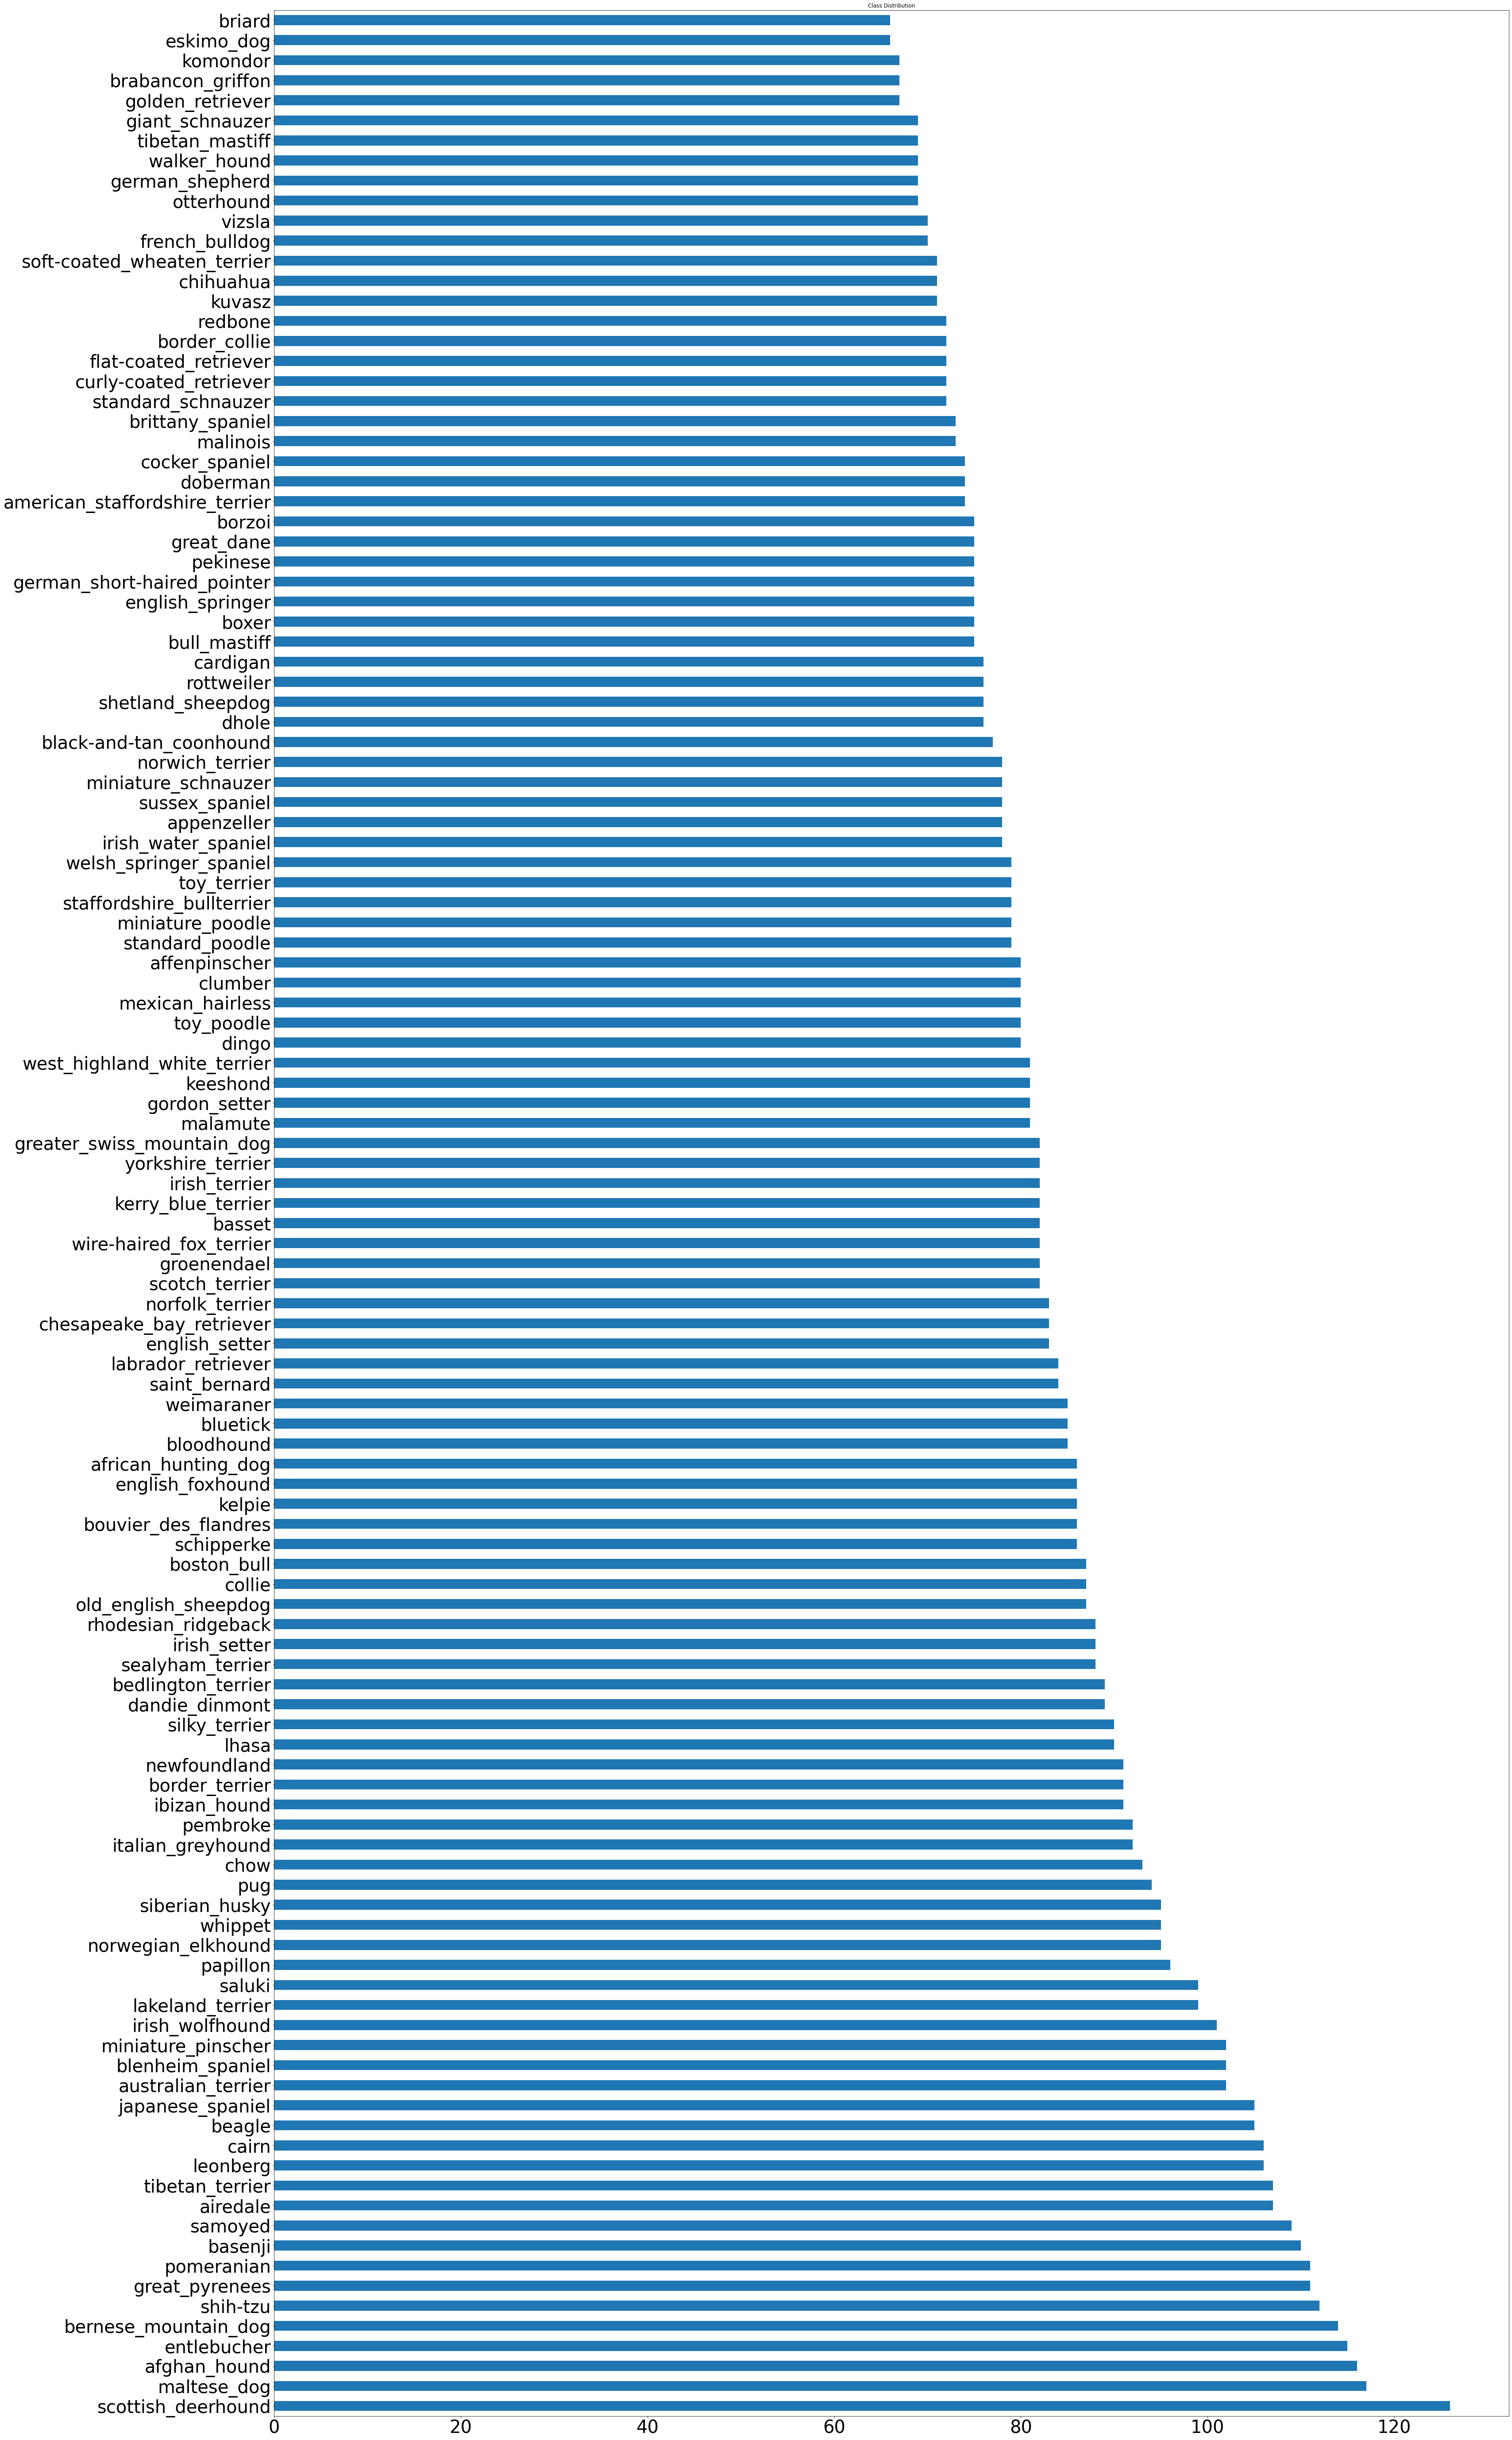

In [187]:


plt.figure(figsize=(50, 100))
traindf['breed'].value_counts().plot(kind='barh',  fontsize="40", title="Class Distribution")
plt.show()


## Visualising Random Sample Images - METHOD 1

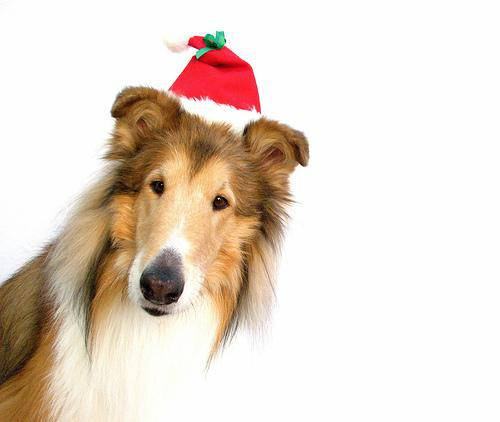

In [188]:


from IPython.display import display, Image
Image(f"C:/Users/conno/Downloads/work/1. Study(main objective)/Artificial Intelligence/4. Intellipaat AI course/Modules/3. AI(DEEP LEARNING)/Assignments/Live-class/Assignment-5/train/0a6c192b96e55e2ca37318919b1ffae6.jpg")

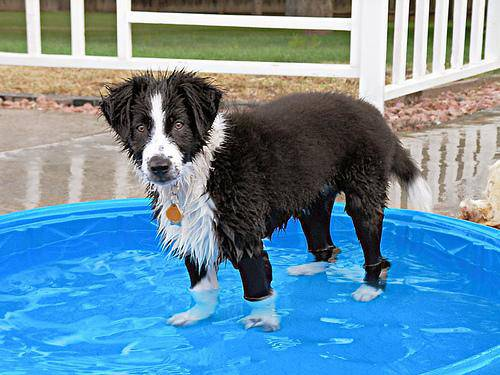

In [189]:
Image(f"C:/Users/conno/Downloads/work/1. Study(main objective)/Artificial Intelligence/4. Intellipaat AI course/Modules/3. AI(DEEP LEARNING)/Assignments/Live-class/Assignment-5/train/9ea6bbd4ff2c706480a2abbe12a8e358.jpg")

### Observations:

The images consist of RGB colors and they might not be closely fitted or cropped
to the dog.
The background may contain water, humans, trees, etc

Overall, if we see, the data distribution seems to be fine. So, we can proceed for further processing and training. Nevertheless, it seems like the data augmentation is needed in this case. So, my approach would be to augment the data first before training as it will provide us with the additional data.

Scottish deerhound is the most preferred breed whereas briard is the least preferred.

### DATA PREPARATION AND AUGMENTATION

In [190]:
## First let's prepare the data before feeding it into the algorithm...

In [191]:
# here we are creating the functions to add the format to all ID in both the train and test datasets

def append_ext(fn):
    return fn+".JPG"

In [192]:
testdf=pd.read_csv("sample_submission.csv",dtype=str)

In [193]:
testdf.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333
1,00102ee9d8eb90812350685311fe5890,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333
2,0012a730dfa437f5f3613fb75efcd4ce,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333
3,001510bc8570bbeee98c8d80c8a95ec1,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333
4,001a5f3114548acdefa3d4da05474c2e,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333


In [194]:
## applying the function to both the datasets...

traindf["id"]=traindf["id"].apply(append_ext)
testdf["id"]=testdf["id"].apply(append_ext)

In [195]:
traindf.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.JPG,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.JPG,dingo
2,001cdf01b096e06d78e9e5112d419397.JPG,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.JPG,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.JPG,golden_retriever


In [196]:
testdf.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e.JPG,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333
1,00102ee9d8eb90812350685311fe5890.JPG,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333
2,0012a730dfa437f5f3613fb75efcd4ce.JPG,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333
3,001510bc8570bbeee98c8d80c8a95ec1.JPG,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333
4,001a5f3114548acdefa3d4da05474c2e.JPG,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,...,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333,0.00833333333333333


### IMPORTING THE DATA

In [197]:
img_width, img_height = 224, 224  #setting image size


train_data_dir = r"C:\Users\conno\Downloads\work\1. Study(main objective)\Artificial Intelligence\4. Intellipaat AI course\Modules\3. AI(DEEP LEARNING)\Assignments\Live-class\Assignment-5\train"

validation_data_dir = r"C:\Users\conno\Downloads\work\1. Study(main objective)\Artificial Intelligence\4. Intellipaat AI course\Modules\3. AI(DEEP LEARNING)\Assignments\Live-class\Assignment-5\test"

nb_train_samples = 10222
nb_validation_samples = 10357

### Data Augmenatation... 

In [200]:
#data_generator = ImageDataGenerator(rescale= 1./255, validation_split=0.2, rotation_range=20,
#                                    zoom_range=0.1, width_shift_range=0.2, height_shift_range=0.2,
#                                    shear_range=0.1, horizontal_flip=True, fill_mode="nearest")



datagen = ImageDataGenerator(
    rescale= 1/255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip=True, validation_split=0.20)
 
## 1. train dataset preparation

train_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory=train_data_dir,
x_col="id",
y_col="breed",
batch_size=16,
subset="training",
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_width, img_height))


## 2. Validation dataset preparation.

valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory=train_data_dir,
x_col="id",
y_col="breed",
subset="validation",
batch_size=16,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_width, img_height))




## 3. Test dataset preparation.

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory=validation_data_dir,
x_col="id",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(img_width, img_height))


Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.
Found 10357 validated image filenames.


In [201]:
train_output = train_generator.next() # everytime this is called, it will produce a next step of images.

In [202]:
images = train_output[0]
labels = train_output[1]

In [203]:
images.shape   # The 32 images per batch as we have specified the batch size above. So, 224 by 224 size three channel images...

(16, 224, 224, 3)

In [204]:
#images[12].shape # The images are 3 channel with size 224,224

### Visualizing the images

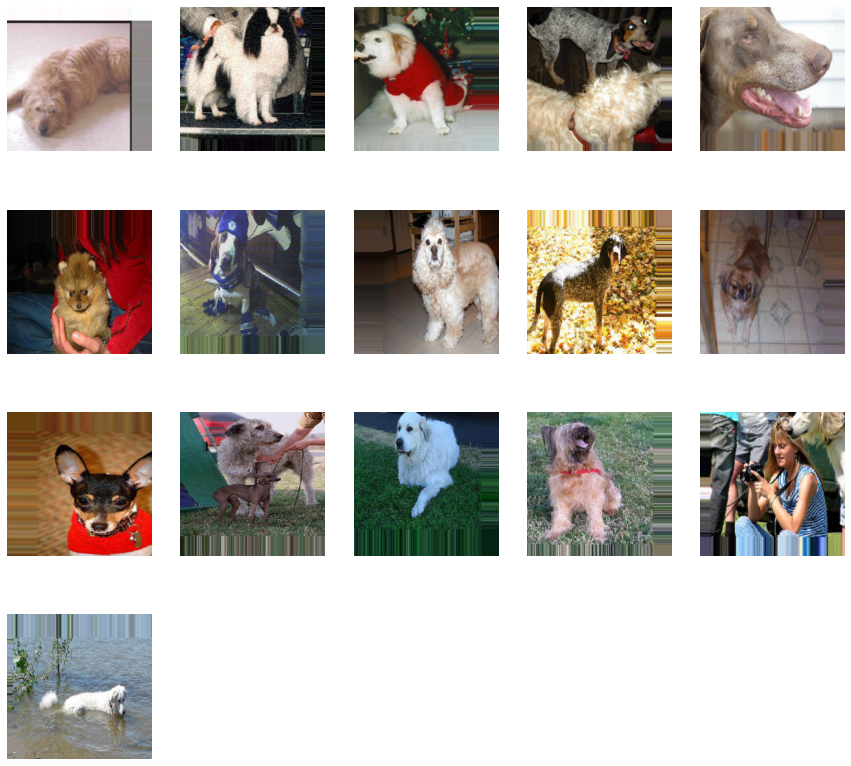

In [205]:
plt.figure(figsize=(15,18))
for i in range(16):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

### Part b):

## Data augmentation

If we have limited number of images per class, then we can use a technique known as data Augmentation. In this technique, we simply produce different variants of the image such as rotation, transaltion and producing same image with different colours. It will help in reducing overfitting and  improve the generalized performance of your model.

### Part c): Model Building

### Architectute-1

In [219]:
# Model Architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(120,activation='softmax'))


model.compile(loss = 'categorical_crossentropy', 
              optimizer = Adam(0.0001),
              metrics=['accuracy'])

#using tensorboard to save the results...

log_dir = r"C:\Users\conno\Downloads\work\1. Study(main objective)\Artificial Intelligence\4. Intellipaat AI course\Modules\3. AI(DEEP LEARNING)\Assignments\Live-class\Assignment-5\logs"


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) 

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 224, 224, 16)      208       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 28, 28, 64)      

### Architecture-2

# Model Architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv2D(filters=256 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(120,activation='softmax'))


model.compile(loss = 'categorical_crossentropy', 
              optimizer = SGD(0.001),
              metrics=['accuracy'])

#using tensorboard to save the results...

log_dir = r"C:\Users\conno\Downloads\work\1. Study(main objective)\Artificial Intelligence\4. Intellipaat AI course\Modules\3. AI(DEEP LEARNING)\Assignments\Live-class\Assignment-5\logs2"


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) 

model.summary()


### Architecture-3

# Model Architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=16, kernel_size=3 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32 , kernel_size=3 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv2D(filters= 256, kernel_size=3 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(120,activation='softmax'))


model.compile(loss = 'categorical_crossentropy', 
              optimizer = Adam(0.0001),
              metrics=['accuracy'])

#using tensorboard to save the results...

log_dir = r"C:\Users\conno\Downloads\work\1. Study(main objective)\Artificial Intelligence\4. Intellipaat AI course\Modules\3. AI(DEEP LEARNING)\Assignments\Live-class\Assignment-5\logs3"


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) #ti log data to tensorboard

model.summary()


In [207]:
#10222 // 32 i.3 319 images will be given to 1 epoch for forward and backward pass

In [208]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history=model.fit(train_generator,
                       steps_per_epoch = STEP_SIZE_TRAIN,  # say 319 images per epoch/ to complete an epoch and no of epochs is 5
                      validation_data = valid_generator,
                      epochs = 12,
                    validation_steps= STEP_SIZE_VALID,
                     callbacks=[tensorboard_callback])

Epoch 1/12
511/511 [==============================] - 229s 447ms/step - loss: 4.7863 - accuracy: 0.0096 - val_loss: 4.7814 - val_accuracy: 0.0094
Epoch 2/12
511/511 [==============================] - 221s 432ms/step - loss: 4.7611 - accuracy: 0.0185 - val_loss: 4.7512 - val_accuracy: 0.0167
Epoch 3/12
511/511 [==============================] - 230s 449ms/step - loss: 4.7239 - accuracy: 0.0179 - val_loss: 4.7201 - val_accuracy: 0.0197
Epoch 4/12
511/511 [==============================] - 196s 382ms/step - loss: 4.6719 - accuracy: 0.0213 - val_loss: 4.6692 - val_accuracy: 0.0226
Epoch 5/12
511/511 [==============================] - 195s 380ms/step - loss: 4.6222 - accuracy: 0.0260 - val_loss: 4.6063 - val_accuracy: 0.0295
Epoch 6/12
511/511 [==============================] - 193s 378ms/step - loss: 4.5625 - accuracy: 0.0341 - val_loss: 4.5706 - val_accuracy: 0.0290
Epoch 7/12
511/511 [==============================] - 193s 378ms/step - loss: 4.5177 - accuracy: 0.0353 - val_loss: 4.5144 -

In [213]:
#Opening tensorboard...
tensorboard --logdir=logs --port 5000

Reusing TensorBoard on port 5000 (pid 12384), started 4:25:18 ago. (Use '!kill 12384' to kill it.)

In [218]:
#starting tensorboard tp visualize the results

#%tensorboard --logdir="C:/Users/conno/Downloads/work/1. Study(main objective)/Artificial Intelligence/4. Intellipaat AI course\Modules/3. AI(DEEP LEARNING)/Assignments/Live-class/Assignment-5/logs3"

In [149]:
# Analyzing metrics

train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_accuracy = model.history.history['accuracy']
validation_accuracy = model.history.history['val_accuracy']

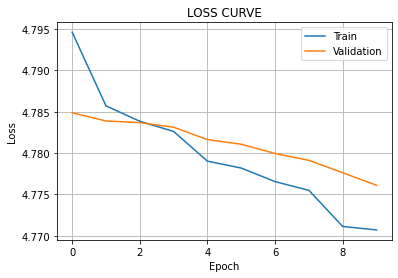

In [150]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LOSS CURVE")
plt.legend(['Train', 'Validation'])
plt.grid()
plt.show()

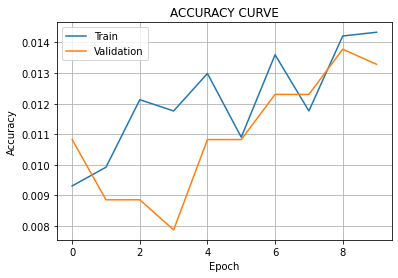

In [151]:
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ACCURACY CURVE")
plt.legend(['Train', 'Validation'])
plt.grid()
plt.show()

## Question-4

The convolutional neural networks(CNN's) are another type of Artificial neural networks(ANN) which mostly deal with image data. We can do operations like image recognition, analyzing the images etc.

Central to the convolutional neural network is the convolutional layer that gives the network its name. This layer performs an operation called a “convolution".

CNN's are better than ANN in the sense that we don't need to flatten the input layer of image matrix is as done in case of ANN's. This in turn prevents pixel distortion(explained in question 1). Another advantage associated with the CNN's is that it is more computationally efficient as compared to ANN because we don't have large set of inputs in it because of elimination of layer flattening. 

Let's say we have a 1000 by 1000, 3 channel image, then the total inputs will be significantly high let's say 3*10^6 in case of ANN. So, we won't able to deal with large-sized, high quality images using ANN as it will be computationally in-efficient. It will have exponentially large number of weights if flattened.


references: https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/


## Question-5


We multiply the gievn image matrix with the kernel/filters to extract it's features. However, it is to be noted that after the filter is multiplied with the image matrix using element by element operation, the size of the output image is reduced. Below is an example depicting the same.


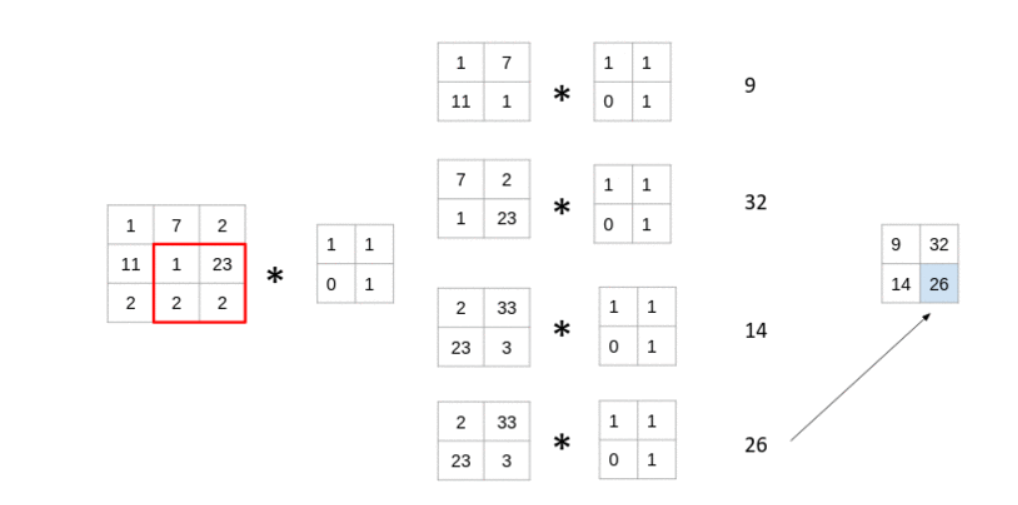

Here, the image matrix is 3 by 3 and the kernel is 2 by 2. Henceforth, the output matrix will be 2 by 2 as shown above.

The general formula to calculate the output matrix is given as:

Dimension of image = (n, n)
Dimension of filter = (f,f) 

Dimension of output will be ((n-f+1) , (n-f+1))

where, n is the input image dimensions.

So, let's say we have a matrix of size 10 by 10 and filter size 3 by 3. Then the output matrix will be (10-3+1) which is 8 by 8 matrix.


A yet another example is shown below:


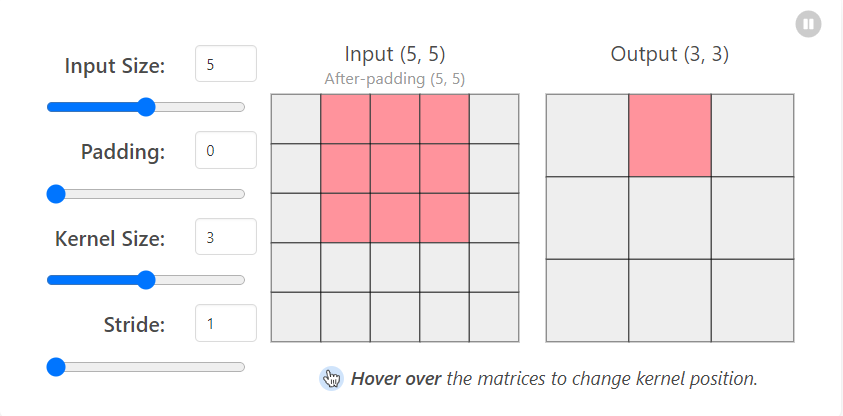

The input image is 5 by 5, the kernel is 3 by 3. So, the resulting output image matrix will be of 3 by 3 size because (5-3+1) is 3.

IMPACT OF STRIDES:

During multiplication of image matrix with kernel, the kernel keeps shifting over pixels. The stride is the measure of how many pixels the kernels will get shifted over while moving from left to right in the image matrix. More the stride value, higher will be the jump of kernel. This will in turn reduce the size of the output matrix as the kernel will be skipping more pixels.


Below are the 2 images compairing the effect of strides



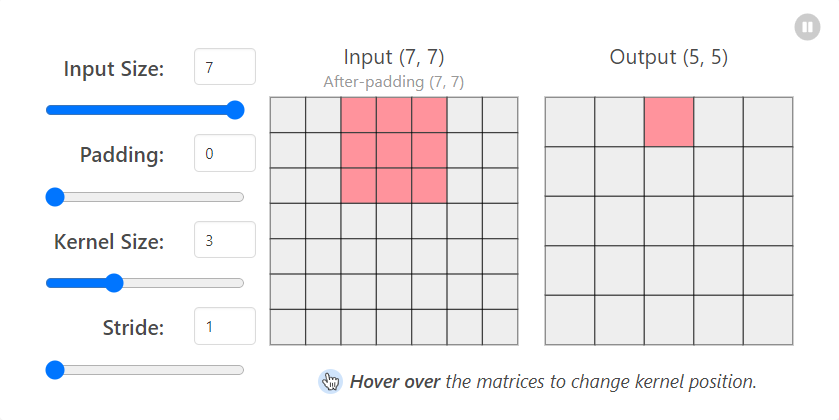

We can clearly see that the size of the output image reduced further by increasing the stride value


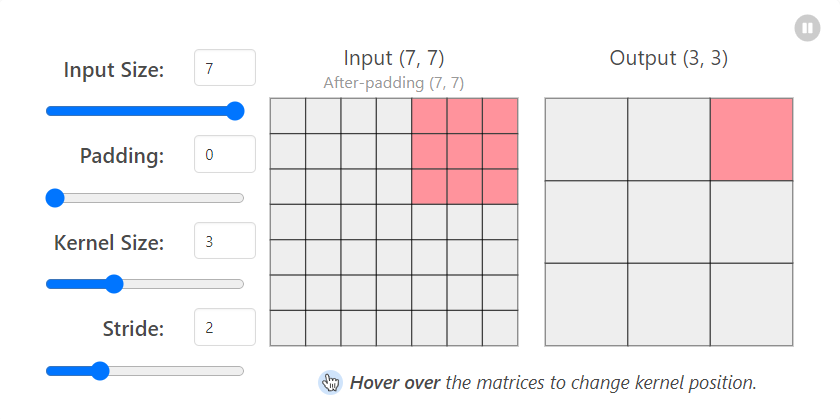





references: 

https://www.analyticsvidhya.com/blog/2020/02/mathematics-behind-convolutional-neural-network/



https://poloclub.github.io/cnn-explainer/

## Question 6


The size of the output image matrix is given as:

Output height = (Input height + padding height top + padding height bottom - kernel height) / (stride height) + 1
Output width = (Output width + padding width right + padding width left - kernel width) / (stride width) + 1

Now, in our case, we have input height as 9 as we have 9 by 9 image. Let's suppose in the beginiing that there is no padding. Also, the kernel size is 2 by 2. The stride is 2. So, the size of the output will be:

                                    Output_Shape = ((9-2+0)/2)+1 = 4
                                    
Padding is needed in order to preserve the size of the output image as after applying filters, the size reduces. In this case, as we can see that the output image has almost become half of the actual size due to which it might lose some features. So, in this case, we need to apply padding layer so that the output image is of decent size. 

Let's apply paddind of 3 by 3. So, the above equation becomes:

                                    Output_Shape = ((9-2+3+3)/2)+1 = 7
  
  
 references: 
 
https://iq.opengenus.org/output-size-of-convolution/#:~:text=Machine%20Learning%20(ML)%20cnn&text=The%20input%20data%20has%20specific,%2F%20(stride%20height)%20%2B%201

### Question 7

The error/loss is the difference between the actual values and the predicted values. Our focus is always on improving the accuracy of our model and reduce both the training set as well as test set errors. But how to do that. Well, there are many approaches that can be adopted to reduce the error for both training as well as testing set.n There can be certain cases where the error doesn't go beyond the certain point.

One of the best strategies is to perform hyper-parameter tuning. In it, we can change parameters like learning rate. Reduced learning rate gives us more accuracy. Second thing, we can do is to increase the number of EPOCHS, which in turns improves the accuracy as the training time increases. Adding regularization, dropout layers also help in case of overfitting(when a model performs well on training data and poorly on test data).  Moreover, changing batch size can also help in reducing the error and improving the accuracy.

We can also add more training data, but in some cases we only have limited number of data and in those cases, we can perform data augmentation.

### References:

#### https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

#### https://towardsdatascience.com/deep-learning-build-a-dog-detector-and-breed-classifier-using-cnn-f6ea2e5d954a

#### https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c